# Lab2 - Concrete compressive strength regression (35 marks total)
Author: *YOUR NAME HERE*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 0. Function definitions (2 marks)

To find the best model, we follow the published article where root-mean squared error (rms) was used as a score function. The rms score function needs to be minimized, because the optimal score is 0, larger values are worse performances

In scikit-learn, only *maximization* is implemented. Hence, it is customary to maximize the *negative* rms. scitkit-learn provides a scoring function `neg_root_mean_squared_error`

In [2]:
from sklearn.model_selection import cross_validate


def get_regressor_neg_rms(model, X, y, cv=7):
    '''Calculate train and validation score for regressor (model) using cross-validation
        
        score is negative root mean-squared error (rms)
        
        model (sklearn classifier): Regressor to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        
        returns: mean training negative rms, mean validation negative rms
    
    '''
    
    
    #TODO: add function body here
    rms = cross_validate(model, X, y, cv=cv, scoring='neg_root_mean_squared_error', return_train_score=True)
    rms_train = rms['train_score'].mean()
    rms_val = rms['test_score'].mean()

    return rms_train, rms_val
    
    

## 1. Load data (1 mark each for 3 total marks)
yellowbrick concrete  
https://www.scikit-yb.org/en/latest/api/datasets/concrete.html

Load the Dataset object with `load_concrete()` using `return_dataset=True`

Print the README of the Dataset object


In [3]:
#TODO: load the yellowbrick concrete Dataset object and access the README
# Import data set
from yellowbrick.datasets import load_concrete
# Load dataset and print readme
conc = load_concrete(return_dataset=True)
print(conc.README)


# Concrete Compressive Strength

**Downloaded from the UCI Machine Learning Repository on October 13, 2016.**

- Multivariate Data Set
- Real Attributes
- 1,030 Instances
- 9 attributes
- Well suited for _regression_ tasks
- [https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength](https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength)

## Abstract

Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients.

## Description

Given are the variable name, variable type, the measurement unit and a brief description. The concrete compressive strength is the regression problem. The order of this listing corresponds to the order of numerals along the rows of the database.

## Attributes

- cement (kg)
- blast furnace slag (kg)
- fly ash (kg)
- water (kg)
- superplasticizer (kg)
- coarse aggregate (kg)
- fine aggregate (kg)
- age (day)
- compressive strength (MPa)

## Citat

### *Question 1:* What is the target variable name and units in this dataset?

*YOUR ANSWER HERE*  


### 1.1 Prepare the feature matrix and target vector
Load the concrete data set into feature matrix `X` and target vector `y`

Print dimensions and type of `X`, `y`

In [4]:
#TODO: Load feature matrix X and target vector y, print shapes
conc_df = conc.to_dataframe()
X = conc_df.drop(columns = "strength")
y = conc_df["strength"]

print(X.shape)
print(y.shape)

(1030, 8)
(1030,)


## 2. Inspect the data (1 mark each for 4 total marks)

### 2.1 Range of each feature
To get an idea if the features are on the same scale, we inspect the range of features

Print the minimum and maximum of each feature in `X`

In [5]:
# TODO: print range (minimum and maximum) of features
for col in conc_df.columns:
    min = conc_df[col].min()
    max = conc_df[col].max()
    print("Feature {}: min={}, max={}".format(col, min, max))

Feature cement: min=102.0, max=540.0
Feature slag: min=0.0, max=359.4
Feature ash: min=0.0, max=200.1
Feature water: min=121.75, max=247.0
Feature splast: min=0.0, max=32.2
Feature coarse: min=801.0, max=1145.0
Feature fine: min=594.0, max=992.6
Feature age: min=1, max=365
Feature strength: min=2.331807832, max=82.5992248


### 2.2 Boxplot of features 
Using seaborn boxplot, plot all features. This provides a visual view of feature ranges

Add y-axis label indicating units, and a title

Text(0.5, 1.0, 'Boxplot of Concrete Features')

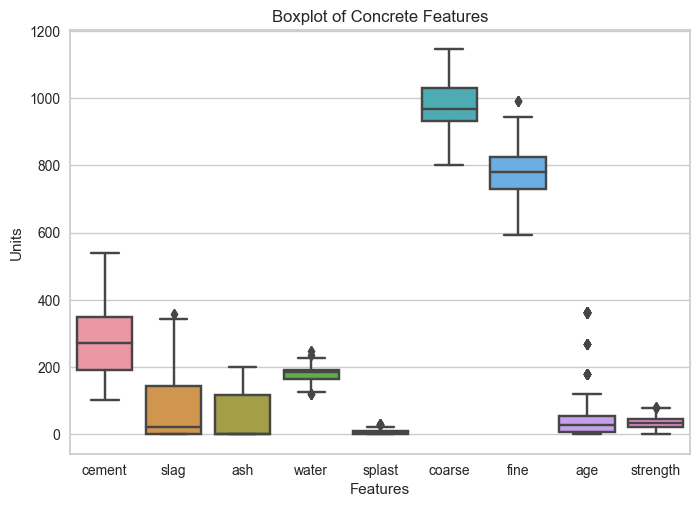

In [6]:
#TODO: add boxplot of features
fig, ax = plt.subplots()
sns.boxplot(data=conc_df, ax = ax)
ax.set_ylabel("Units")
ax.set_xlabel("Features")
ax.set_title("Boxplot of Concrete Features")

### 2.3 Correlation heatmap of features 

To understand if pairs of features are potentially related, contain similar information, pair-wise cross-correlation can be calculated. Models benefit most from un-correlated features.

Using pandas `corr()` method, create the cross-correlations between all features. Plot this cross-correlation object using seaborn `heatmap()` with parameters `vmin=-1, vmax=1, annot=True, cmap='BrBG'`. Add a title.

Pandas `corr()` calculates [Pearson correlation ](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) :
>  It has a value between +1 and −1. A value of +1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation.

[Text(0.5, 1.0, 'Pairwise Cross-Correlation')]

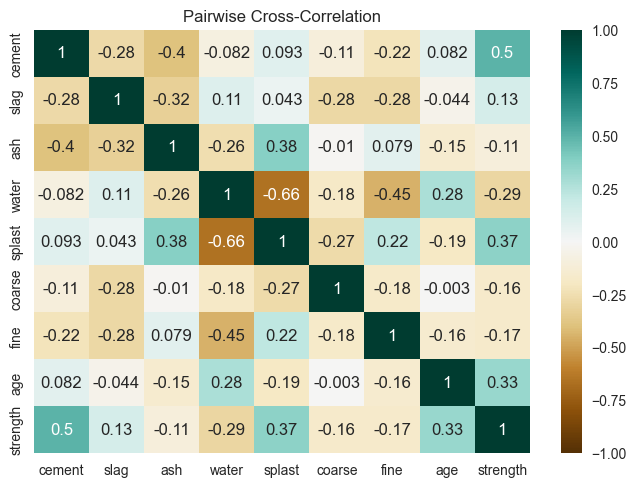

In [7]:
# TODO: add pairwise cross-correlation heatmap of features
conc_corr = conc_df.corr()

sns.heatmap(conc_corr, vmin=-1, vmax=1, annot=True, cmap='BrBG').set(title = "Pairwise Cross-Correlation")

### 2.4 Histogram of target variable 

To understand if all target values are equally represented in the data, we analyze how many samples of each target value we have available. The histogram of the target vector can visualize this distribution.

Using seaborn `displot()`, plot the histogram of the target vector. Add a title.

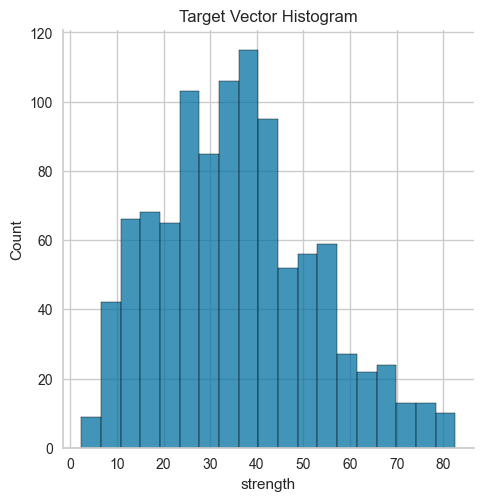

In [8]:
#TODO: Add histogram of targect vector
sns.displot(data = y).set(title= "Target Vector Histogram")

## 3. Create training and test sets (1 mark)

Using scikit-learn `train_test_split()` with parameters `random_state=37`, `test_size=0.2`, split `X` and `y` into training and test sets

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# TODO: train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

## 4. Compare models using cross-validation (3 marks)

Create a list containing a `LinearRegression()`, `RandomForestRegressor(random_state=64)` and `GradientBoostingRegressor(random_state=79)` objects.

Iterate this list and:
- using `X_train` and `y_train`
- compute the negative root mean-squared error using the `get_regressor_neg_rms()` function
- and print the training and validation scores with **2 decimal places**
- Use 7-fold cross-validation

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [12]:
#TODO: Calling get_regressor_neg_rms() for each model
models = [LinearRegression(), RandomForestRegressor(random_state=64), GradientBoostingRegressor(random_state=79)]

for model in models:
    train_score, val_score = get_regressor_neg_rms(model, X_train, y_train, cv=7)
    print(f"{type(model).__name__}: \n  Training score: {train_score:.2f}\n  Validation score: {val_score:.2f}")

LinearRegression: 
  Training score: -10.29
  Validation score: -10.39
RandomForestRegressor: 
  Training score: -2.12
  Validation score: -4.97
GradientBoostingRegressor: 
  Training score: -3.69
  Validation score: -4.98


### *Question 2:* For each of the three models, state if models are potentially over- or underfitting and why (3 marks)

*YOUR ANSWER HERE*  
1. LinearRegression: The training and validation score are both high but close in value. This indicates that the model is likely fitted correctly but may not be the best model.
2. RandomForestRegressor: The validation score is larger than the training score indicating that the model may be underfit.
3. GradientBoostingRegressor: The validation score is larger than the training score indicating that the model may be underfit.


## 5. Find a better model (3 marks)

Use the `RandomForestRegressor(random_state=64)` and find the best combination of `max_depth` from the list of `[10, 15, 20]`, and `n_estimators` from the list of `[100, 200, 400]`

Use nested for-loops to iterate these two lists:
- using `X_train` and `y_train`
- compute the negative root mean-squared error of the corresponding `RandomForestRegressor(random_state=64)` using the `get_regressor_neg_rms()` function 
- and print the training and validation scores with **2 decimal places**
- Use 7-fold cross-validation

Report the best validation score and the corresponding model

Note: We expect that more trees (larger `n_estimators`) yield better model performance

In [13]:
#TODO: Using nested for loops iterate parameter combinations and print results
max_depth = [10,15,20]
n_estimators = [100,200,400]

for depth in max_depth:
    for n in n_estimators:
        model = RandomForestRegressor(max_depth=depth, n_estimators=n, random_state=64)

        train_score, val_score = get_regressor_neg_rms(model, X_train, y_train, cv=7)

        print(f"{type(model).__name__}(Depth = {depth}, Estimators = {n}): \n  Training score: {train_score:.2f}\n  Validation score: {val_score:.2f}")



        
train_score, val_score = get_regressor_neg_rms(RandomForestRegressor(random_state=64), X_train, y_train, cv=7)

RandomForestRegressor(Depth = 10, Estimators = 100): 
  Training score: -2.44
  Validation score: -5.09
RandomForestRegressor(Depth = 10, Estimators = 200): 
  Training score: -2.42
  Validation score: -5.06
RandomForestRegressor(Depth = 10, Estimators = 400): 
  Training score: -2.41
  Validation score: -5.06
RandomForestRegressor(Depth = 15, Estimators = 100): 
  Training score: -2.12
  Validation score: -4.97
RandomForestRegressor(Depth = 15, Estimators = 200): 
  Training score: -2.11
  Validation score: -4.93
RandomForestRegressor(Depth = 15, Estimators = 400): 
  Training score: -2.10
  Validation score: -4.93
RandomForestRegressor(Depth = 20, Estimators = 100): 
  Training score: -2.12
  Validation score: -4.97
RandomForestRegressor(Depth = 20, Estimators = 200): 
  Training score: -2.11
  Validation score: -4.93
RandomForestRegressor(Depth = 20, Estimators = 400): 
  Training score: -2.09
  Validation score: -4.92


### *Question 3:* Which combination of `max_depth` and `n_estimators` produced the best validation score? Report both training and validation scores here (2 marks)

*YOUR ANSWER HERE*  
The best combination is the RandomForestRegressor with max_depth 20 and 400 n_estimators. The training score was -2.09 and the validation score was -4.92. 

## 6. Retrain best model (2 marks)

Create a `RandomForestRegressor(random_state=64)` with the best pair of `max_depth` and `n_estimators`, and retrain this model on all training data.

In [14]:
#TODO: retrain the best estimator
best_model = RandomForestRegressor(max_depth=20, n_estimators=400, random_state=64)
best_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=400, random_state=64)

## 7. Evaluate best model on training and test data
### 7.1 Root mean-squared error and $R^2$ (3 marks)

For the retrained best estimator, print the root mean-squared error (**2 decimal places**) and R-squared (**3 decimal places**) for training and test sets.

In [15]:
from sklearn.metrics import mean_squared_error, r2_score

In [16]:
# TODO: print rms and r-squared for training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# root mean squared scores
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred, squared= False)


# r squared scores
train_r_sq = r2_score(y_train, y_train_pred)
test_r_sq = r2_score(y_test, y_test_pred)
print(f"Training RMS: {train_rmse:.2f}\nTraining R2: {train_r_sq:.2f}")
print(f"Testing RMS: {test_rmse:.2f}\nTesting R2: {test_r_sq:.2f}")


Training RMS: 2.00
Training R2: 0.99
Testing RMS: 4.80
Testing R2: 0.92


### *Question 4:* How does this test score compare to the polynomial regression and neural network reported in the article? Do we outperform the reported models? Include scores in your answer. (2 marks)

*YOUR ANSWER HERE*
The root mean squared value for the test set for the Random Forest (RMS = 4.8 MPa) performs better than the polynomial (RMS = 8.82 MPa) but worse than the neural network (RMS = 4.32 MPa). The r squared value for the test set for the Random Forest (R2 = 0.92) was higher than the polynomial (R2 = 0.791) and worse than the neural network value (R2 = 0.929).

The root mean squared value for the training set of the Random Forest (RMS = 2.00 MPa) performed better thanthe polynomial model (RMS = 3.96 MPa) and the neural network (RMS = 3.01 MPa). The r squared value of the training set for the Random Forest (R2 = 0.99) was higher than the polynomial (R2 = 0.89) and the neural network value (R2 = 0.94).

### 7.2 Predicted vs actual strength plot (1 mark)
Using a scatterplot, show predicted strength on the x axis and actual strength on the y axis with data from the test set. With this plot, we can see where we make errors.

Add a line of unity (diagonal with slope 1 and offset 0). Ideally, all points would be on this line. We look for points being distributed equally around the line of unity.

Add x-axis, y-axis labels including units, and a title.


Text(0.5, 1.0, 'Predicted vs Actual Strength (Test Set)')

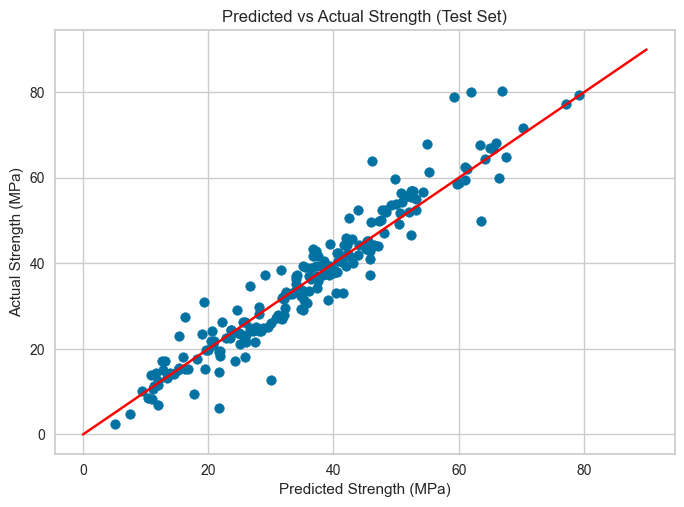

In [17]:
#TODO: predicted-actual plot
plt.scatter(y_test_pred, y_test)
plt.plot([0,90], [0,90], color = 'red')
plt.xlabel('Predicted Strength (MPa)')
plt.ylabel('Actual Strength (MPa)')
plt.title('Predicted vs Actual Strength (Test Set)')

### 7.3 Residual plot (1 mark)
Using a scatterplot, show predicted strength on the x axis and the *difference* between actual and predicted strength on the y axis with data from the test set. This is an alternative way to see where errors are made.

We look for residuals being distributed equally around the zero horizontal line.

Add x-axis, y-axis labels including units, and a title.



Text(0.5, 1.0, 'Predicted vs Actual Strength (Test Set)')

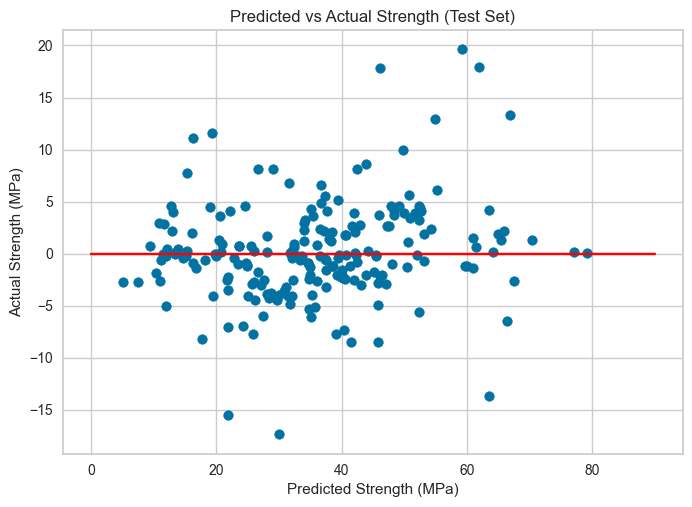

In [18]:
# TODO: Residual plot
diff = y_test - y_test_pred

plt.scatter(y_test_pred, diff)
plt.plot([0,90], [0,0], color = 'red')
plt.xlabel('Predicted Strength (MPa)')
plt.ylabel('Actual Strength (MPa)')
plt.title('Predicted vs Actual Strength (Test Set)')

## 8. Conclusion (3 marks)

In conclusion, comment on the following items:
1. Did we find a model that outperforms the polynomial regression reported in the reference article? Explain.
1. Did we find a model that outperforms the neural network reported in the reference article? Explain.
1. What were our assumption about the dataset and train/test split? How do these assumptions affect your conclusions?


*YOUR ANSWER HERE*
1. Yes, our model out performed the polynomial regression model as it had a lower RMS value on the testing set (RandomForest: 4.8 MPa vs Polynomial: 8.82 MPa) and a higher R2 value (RandomForest:0.92 vs Polynomial:0.791).
2. No our model does not out perform the neural network as it had a higher RMS value (RandomForest: 4.8 MPa vs Neural Network:4.32 MPa) and a lower R2 value (RandomForest: 0.92 vs Neural Network: 0.93 MPa)
3. We assume that the dataset accurately represents the population so that it can accurately predict new data. In terms of the train/test split we assume that split is random.

## 9. Reflection (2 marks)



Include a sentence or two about:
- what you liked or disliked,
- found interesting, confusing, challangeing, motivating while working on this assignment.

It was very interesting to use programming to determine the best Random Forest Model by using a nested for loop. This was a quick and efficient way to test 9 different models and could be scaled easily. It was interesting to be able to compare a model to others and see how it compares better or worse. This assignment was particularly interesting to me as a previous building engineer who worked with a lot of concrete.

I liked how the assignment loosely guided you through the process but did not give too much of the answer. I feel like it struck the correct difficulty without allowing students to spin their wheels or be too easy.  

# Appendix-A: Bonus - use grid search to find the best model parameters
### (5 potential bonus marks)

## A-0. Workflow overview

In [ ]:
import mglearn
mglearn.plots.plot_grid_search_overview()

## A-1. Hyperparameter tuning using grid search (2 marks)

The inital cross-validation above showed that both DecisionTree based models might have merit. Next, the hyperparameters are tuned using grid search.

### A-1.1 Grid search for RandomForestRegressor

Perform grid search using `GridSearchCV` for the `RandomForestRegressor(random_state=64)`.

Grid search to use 7-fold cross-validation, and `neg_root_mean_squared_error` as the scoring function.

Use the following hyperparameters and values:
- `'n_estimators': [100, 200, 400]`
- `'max_depth': [ 15, 17, 19, 21]`
- `'max_features': ['auto', 'log2', None]`


In [ ]:
# TODO: Setup grid search for RandomForestRegressor(random_state=64)


In [ ]:
# TODO: perform the grid search by calling fit()


In [ ]:
# TODO: Print the best parameters


In [ ]:
# TODO: Print the best score


### A-1.2 Grid search for gradient boosted tree

Perform grid search using `GridSearchCV` for the `GradientBoostingRegressor(random_state=79)`.

Grid search to use 7-fold cross-validation, and `neg_root_mean_squared_error` as the scoring function.

Use the following hyperparameters and values:
- `'n_estimators': [100, 200, 500]`
- `'max_depth': [1, 3, 5, 7]`
- `'learning_rate': [0.01, 0.1, 1.0]`

In [ ]:
# TODO: Setup grid search for GradientBoostingRegressor(random_state=79)


In [ ]:
# TODO: perform the grid search by calling fit()


In [ ]:
# TODO: Print the best parameters


In [ ]:
# TODO: Print the best score


### *Question A-1:* Which of the two models produces the best score? What is the best score?

*YOUR ANSWER HERE*


## A-2. Retrain best model (1 mark)

Get the best estimator from the two grid searches above and retrain this model on all training data.

In [ ]:
#TODO: retrain the best estimator



## A-3. Model evaluation and conclusion (1 mark)

Repeat steps in Section 7 above for the best model.

Revisit your Question 4.

In [ ]:
#TODO: train and test set scores of retrained best model


In [ ]:
#TODO: predicted-actual plot


In [ ]:
# TODO: Residual plot


### *Question A-4:* How does this test score compare to the polynomial regression and neural network reported in the article? Do we outperform the reported models? (1 mark)

*YOUR ANSWER HERE*
